In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import torch
import numpy as np
import torch.utils.data
from sklearn.model_selection import train_test_split
import pandas as pd
import qutip as qt

In [2]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from reservoirgrid.models import CQOscRes
from reservoirgrid.datasets import SineSquare

import plotly.graph_objects as go

In [3]:
import numpy as np
import qutip as qt

# Parameters
omega_a = 10 * 2 * np.pi  # 10 GHz
omega_b = 9 * 2 * np.pi   # 9 GHz
kappa_a = 17 * 2 * np.pi  # 17 MHz
kappa_b = 21 * 2 * np.pi  # 21 MHz
g = 700 * 2 * np.pi       # 700 MHz
N = 8  # Hilbert space truncation

# Operators
a = qt.tensor(qt.destroy(N), qt.qeye(N))
b = qt.tensor(qt.qeye(N), qt.destroy(N))

# Hamiltonian (static part)
H_static = omega_a * a.dag() * a + omega_b * b.dag() * b + g * (a * b.dag() + a.dag() * b)

# Time-dependent drive (Option 1: Function-based)
times = np.linspace(0, 100e-9, 100)  # 100 ns simulation
x_i = np.sin(2 * np.pi * 1e8 * times)  # Example input

def drive_coeff(t):
    t_idx = np.argmin(np.abs(times - t))
    return x_i[t_idx]

# Drive Hamiltonian (applied to oscillator 'a')
epsilon_0 = 500e6 * np.sqrt(1e-3) 
H_drive = [epsilon_0 * np.sqrt(2 * kappa_a) * (a + a.dag()), drive_coeff]

# Collapse operators (dissipation)
c_ops = [np.sqrt(kappa_a) * a, np.sqrt(kappa_b) * b]

# Initial state (|00⟩)
psi0 = qt.tensor(qt.basis(N, 0), qt.basis(N, 0))

# Simulate

result = qt.mesolve([H_static, H_drive], psi0, times, c_ops, [])

/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/qutip/solver/solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [4]:
dataset = SineSquare(len(times)+8)
data, label = dataset.get_all()
data = data.flatten().detach().numpy()
len(times), len(data[:100])

(100, 100)

In [5]:
H_drive2 = [epsilon_0 * np.sqrt(2 * kappa_a) * (a + a.dag()), data[:100]]

In [6]:
result = qt.mesolve([H_static, H_drive2], psi0, times, c_ops, [])

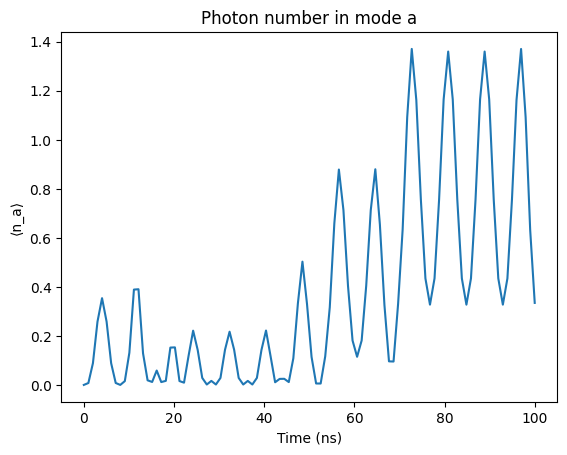

In [7]:
n_a = qt.expect(a.dag() * a, result.states)
plt.plot(times * 1e9, n_a)
plt.xlabel("Time (ns)")
plt.ylabel("⟨n_a⟩")
plt.title("Photon number in mode a")
plt.show()

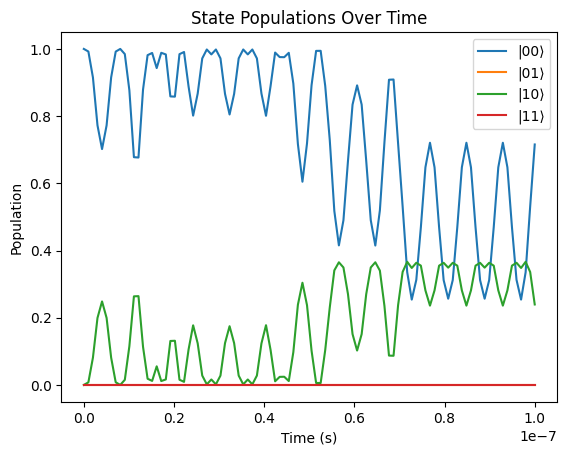

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Extract populations of |00⟩, |01⟩, |10⟩, |11⟩
populations = [
    [
        qt.expect(
            qt.tensor(qt.fock_dm(N, i), qt.fock_dm(N, j)),  # |i⟩⟨i| ⊗ |j⟩⟨j|
            state
        )
        for i in range(2) for j in range(2)  # Loop over i,j ∈ {0,1}
    ]
    for state in result.states  # Loop over all time steps
]

# Convert to NumPy array (shape: [n_timesteps, 4])
populations = np.array(populations)

# Plot
plt.plot(times, populations)
plt.xlabel("Time (s)")
plt.ylabel("Population")
plt.legend(["|00⟩", "|01⟩", "|10⟩", "|11⟩"])
plt.title("State Populations Over Time")
plt.show()

In [9]:
from reservoirgrid.helpers import utils
from reservoirgrid.models import Reservoir

In [10]:
dataset = np.genfromtxt("../reservoirgrid/datasets/Lorenz_fine.csv", delimiter=",", skip_header=1)
dataset = dataset[:, 1:]  # Remove time column

dataset = utils.normalize_data(dataset)
train_data, test_data = train_test_split(dataset, test_size=0.2, shuffle=False)

input_train = torch.tensor(train_data[:-1],dtype=torch.float32)
input_test = torch.tensor(test_data[:-1],dtype=torch.float32)
target_train = torch.tensor(train_data[1:],dtype=torch.float32)
target_test = torch.tensor(test_data[1:],dtype=torch.float32)
dataset = torch.tensor(dataset, dtype=torch.float32)

print(input_train.shape, target_train.shape, input_test.shape, target_test.shape)

torch.Size([7999, 3]) torch.Size([7999, 3]) torch.Size([1999, 3]) torch.Size([1999, 3])


Readout training complete.
0.29565128684043884


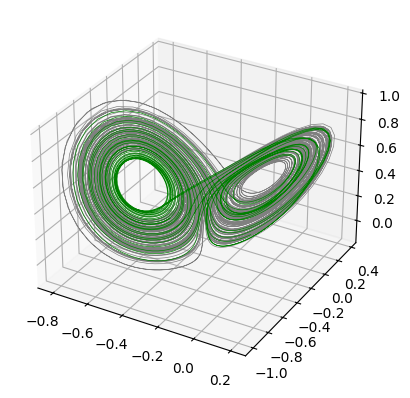

In [11]:
reservoir = Reservoir(
    input_dim=3,
    reservoir_dim=1000,
    output_dim=3,
    spectral_radius=0.95,
    leak_rate=0.55,
    sparsity=0.8,
    input_scaling=0.5,
    noise_level = 0.01
)

reservoir.train_readout(input_train, target_train, warmup=200)

predictions = reservoir.predict(input_train, len(target_test))
print(reservoir.RMSE(target_test, predictions))
predictions = predictions.detach().cpu().numpy()

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(dataset[:, 0], dataset[:, 1], dataset[:, 2], 'gray', linewidth=0.5)
ax.plot3D(predictions[:, 0], predictions[:, 1], predictions[:, 2], linewidth=0.5, color='green')
plt.show()

In [12]:
map = torch.rand(len(input_train),3) > 0.5

In [13]:
torch.zeros(1).expand(5, -1)

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [14]:
torch.zeros(1).expand(5)

tensor([0., 0., 0., 0., 0.])

In [51]:
import dysts
from dysts.systems import make_trajectory_ensemble
all_out = make_trajectory_ensemble(10, resample=True, pts_per_period=1)

Integrating systems:   0%|          | 0/135 [00:00<?, ?it/s]/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/dysts/base.py:301: UserWarning: Expect slowdown due to excessive integration required; scale factor 4999.166666666757
  warnings.warn(
Integrating systems:   1%|          | 1/135 [00:04<09:15,  4.15s/it]/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/dysts/base.py:301: UserWarning: Expect slowdown due to excessive integration required; scale factor 4999.166666666667
  warnings.warn(
Integrating systems:   1%|▏         | 2/135 [00:09<10:37,  4.79s/it]/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/dysts/base.py:301: UserWarning: Expect slowdown due to excessive integration required; scale factor 4999.166666667697
  warnings.warn(
Integrating systems:   2%|▏         | 3/135 [00:13<10:18,  4.69s/it]/home/ragedpi/Reservoir_Pytorch/.venv/lib64/python3.13/site-packages/dysts/base.py:301: UserWarning: Expect slowdown due to 

KeyboardInterrupt: 

In [49]:
system = list(all_out)
system

['Aizawa',
 'AnishchenkoAstakhov',
 'Arneodo',
 'ArnoldBeltramiChildress',
 'ArnoldWeb',
 'AtmosphericRegime',
 'BeerRNN',
 'BelousovZhabotinsky',
 'BickleyJet',
 'Blasius',
 'BlinkingRotlet',
 'BlinkingVortex',
 'Bouali',
 'Bouali2',
 'BurkeShaw',
 'CaTwoPlus',
 'CaTwoPlusQuasiperiodic',
 'CellCycle',
 'CellularNeuralNetwork',
 'Chen',
 'ChenLee',
 'Chua',
 'CircadianRhythm',
 'CoevolvingPredatorPrey',
 'Colpitts',
 'Coullet',
 'Dadras',
 'DequanLi',
 'DoubleGyre',
 'DoublePendulum',
 'Duffing',
 'ExcitableCell',
 'Finance',
 'FluidTrampoline',
 'ForcedBrusselator',
 'ForcedFitzHughNagumo',
 'ForcedVanDerPol',
 'GenesioTesi',
 'GlycolyticOscillation',
 'GuckenheimerHolmes',
 'Hadley',
 'Halvorsen',
 'HastingsPowell',
 'HenonHeiles',
 'HindmarshRose',
 'Hopfield',
 'HyperBao',
 'HyperCai',
 'HyperJha',
 'HyperLorenz',
 'HyperLu',
 'HyperPang',
 'HyperQi',
 'HyperRossler',
 'HyperWang',
 'HyperXu',
 'HyperYan',
 'HyperYangChen',
 'IkedaDelay',
 'InteriorSquirmer',
 'IsothermalChemical',

(10, 3)


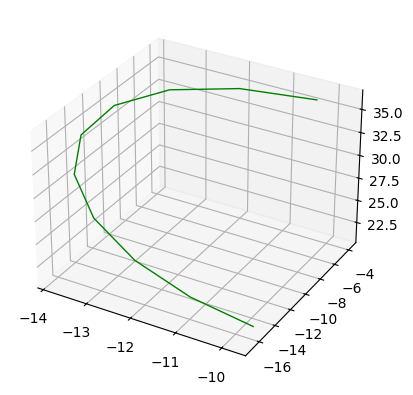

In [50]:
system = list(all_out)[18]
array = all_out['Lorenz']
print(array.shape)
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot3D(array[:, 0], array[:, 1], array[:, 2], 'green', linewidth=1)
plt.show()